# Miller age

In [1]:
%load_ext autoreload
%autoreload 2
# # this may cause DisentenglementTargetManager to reimported, losing all the data e.g. configurations.

In [2]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats

sys.path.append("/Users/kemalinecik/git_nosync/tardis")
import tardis
tardis.config = tardis.config_local
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/Users/kemalinecik/git_nosync/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [4]:
ood_seed = 42
num_ood = 1

In [5]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

def adata_ood_creator(adata, seed, size):
    adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
    adata.obs["age_continuous"] = adata.obs["age"].astype(float)
    df = adata.obs.groupby(["cell_type", "age"]).size()
    df2 = adata.obs.groupby(["cell_type"]).size()
    availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 350]
    rng = np.random.default_rng(seed=seed)
    random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    choices = [availables[i] for i in random_choices]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('Bud tip adjacent cells', '18.0'), 777)

Removed datapoint: 777


In [6]:
adata

AnnData object with n_obs × n_vars = 6628 × 8192
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes', 'age_continuous'
    uns: 'rank_genes_groups'
    obsm: 'Unintegrated', 'X_pca', 'harmony'

In [7]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"miller_age_ood-seed-{ood_seed}"
)

In [8]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [9]:
(
    adata.obs["integration_donor"].nunique(),
    adata.obs["integration_biological_unit"].nunique(),
    adata.obs["integration_sample_status"].nunique(),
    adata.obs["integration_library_platform_coarse"].nunique(),
) 

(8, 1, 1, 1)

In [10]:
warmup_epoch_range = None
# _, n_epochs_kl_warmup = warmup_epoch_range
n_epochs_kl_warmup = 400

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

tardis_loss_weight_1 = 200
tardis_loss_weight_2 = 20

disentenglement_targets_configurations=[
    dict(
        obs_key = "age",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = tardis_loss_weight_1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = tardis_loss_weight_2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = tardis_loss_weight_1,
                method = "mse_z", 
                latent_group = "unreserved",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = tardis_loss_weight_2, 
                method = "mse_z", 
                latent_group = "unreserved",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "integration_donor",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = tardis_loss_weight_1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = tardis_loss_weight_2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = tardis_loss_weight_1,
                method = "mse_z", 
                latent_group = "unreserved",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = tardis_loss_weight_2, 
                method = "mse_z", 
                latent_group = "unreserved",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=40, 
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.1,
    include_auxillary_loss = True
)

train_params = dict(
    max_epochs=300,
    train_size=0.8,
    batch_size=512,
    check_val_every_n_epoch=10,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-3,
        weight_decay=1e-6,
        # optimizer="AdamW"
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    ),
    limit_train_batches=0.5, 
    limit_val_batches=0.5,
)

dataset_params = dict(
    layer=None, 
    labels_key="cell_type",
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations
)

tardis.MyModel.setup_anndata(adata, **dataset_params)

# tardis.MyModel.setup_wandb(
#     wandb_configurations=tardis.config.wandb,
#     hyperparams=dict(
#         model_params=model_params,
#         train_params=train_params,
#         dataset_params=dataset_params,
#     )
# )

vae = tardis.MyModel(
    adata, 
    deeply_inject_disentengled_latents=True, 
    encode_covariates=True,
    beta_kl_weight=1.0,
    **model_params
)
vae.train(**train_params)

# vae.save(
#     dir_path,
#     overwrite=True,
# )

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/kemalinecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/kemalinecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/Users/kemalinecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if yo

Epoch 1/300:   0%|          | 0/300 [00:00<?, ?it/s]

/Users/kemalinecik/git_nosync/tardis/tardis/_counteractivegenerator.py:231: UserWarning: Possible group definition indices are calculated for `age` for `training` set. Number of elements in each group: 558,2341,1778,626
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/Users/kemalinecik/git_nosync/tardis/tardis/_counteractivegenerator.py:231: UserWarning: Possible group definition indices are calculated for `integration_donor` for `training` set. Number of elements in each group: 255,303,549,254,1538,931,847,626
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 2/300:   0%|          | 1/300 [00:01<07:12,  1.45s/it, v_num=1, total_loss_train=1.97e+3, kl_local_train=15.6, tardis_age_0_train=101, tardis_age_1_train=24.8, tardis_age_2_train=209, tardis_age_3_train=10.9, tardis_integration_donor_0_train=103, tardis_integration_donor_1_train=24, tardis_integration_donor_2_train=212, tardis_integration_donor_3_train=10.9]

/Users/kemalinecik/git_nosync/tardis/tardis/_counteractivegenerator.py:231: UserWarning: Possible group definition indices are calculated for `age` for `validation` set. Number of elements in each group: 149,583,450,143
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/Users/kemalinecik/git_nosync/tardis/tardis/_counteractivegenerator.py:231: UserWarning: Possible group definition indices are calculated for `integration_donor` for `validation` set. Number of elements in each group: 71,78,134,52,397,255,195,143
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 300/300: 100%|██████████| 300/300 [06:59<00:00,  1.40s/it, v_num=1, total_loss_train=1.28e+3, kl_local_train=76.2, tardis_age_0_train=104, tardis_age_1_train=6, tardis_age_2_train=48.5, tardis_age_3_train=16.2, tardis_integration_donor_0_train=114, tardis_integration_donor_1_train=10.6, tardis_integration_donor_2_train=55, tardis_integration_donor_3_train=17.9]      

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [06:59<00:00,  1.40s/it, v_num=1, total_loss_train=1.28e+3, kl_local_train=76.2, tardis_age_0_train=104, tardis_age_1_train=6, tardis_age_2_train=48.5, tardis_age_3_train=16.2, tardis_integration_donor_0_train=114, tardis_integration_donor_1_train=10.6, tardis_integration_donor_2_train=55, tardis_integration_donor_3_train=17.9]


In [11]:
from tardis._disentanglementmanager import DisentanglementManager as DM

In [12]:
vae.get_MI_normalized_training("age")

{('validation', 'reserved'): 0.7353345519299288,
 ('validation', 'unreserved'): 0.40580040336451084,
 ('train', 'reserved'): 0.8027867489916417,
 ('train', 'unreserved'): 0.27122975199252186}

In [13]:
vae.get_MI_normalized_training("integration_donor")

{('validation', 'reserved'): 0.5919486067532376,
 ('validation', 'unreserved'): 0.5014384443890049,
 ('train', 'reserved'): 0.5028764900553109,
 ('train', 'unreserved'): 0.35849804805531216}

In [14]:
vae.get_knn_purity_training("age")

{('validation', 'reserved'): 0.8912950591330355,
 ('validation', 'unreserved'): 0.8156405453737985,
 ('train', 'reserved'): 0.9689655723699353,
 ('train', 'unreserved'): 0.9431531962341129}

In [15]:
vae.get_knn_purity_training("integration_donor")

{('validation', 'reserved'): 0.6219534506118476,
 ('validation', 'unreserved'): 0.635544934444279,
 ('train', 'reserved'): 0.8285972183563834,
 ('train', 'unreserved'): 0.8126104789782913}

In [16]:
vae.get_get_reconstruction_r2_training(batch_size=512)

{('validation', 'total'): 0.8013995930258382,
 ('validation', 'DEG-16'): 0.3989847486876245,
 ('validation', 'DEG-64'): 0.7106389148970716,
 ('train', 'total'): 0.8307264538717817,
 ('train', 'DEG-16'): 0.5752247424630818,
 ('train', 'DEG-64'): 0.7357678915398271}

In [17]:
# Convert string to integers
adata.obs['age_continuous'] = adata.obs['age'].astype(float)
adata.obs['age_training'] = adata.obs['age_continuous'].rank(method='dense').astype(int)

In [18]:
adata.obs[['age_training', 'age']].value_counts()

age_training  age 
2             15.0    2924
3             18.0    2228
4             21.0     769
1             11.5     707
dtype: int64

In [19]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)

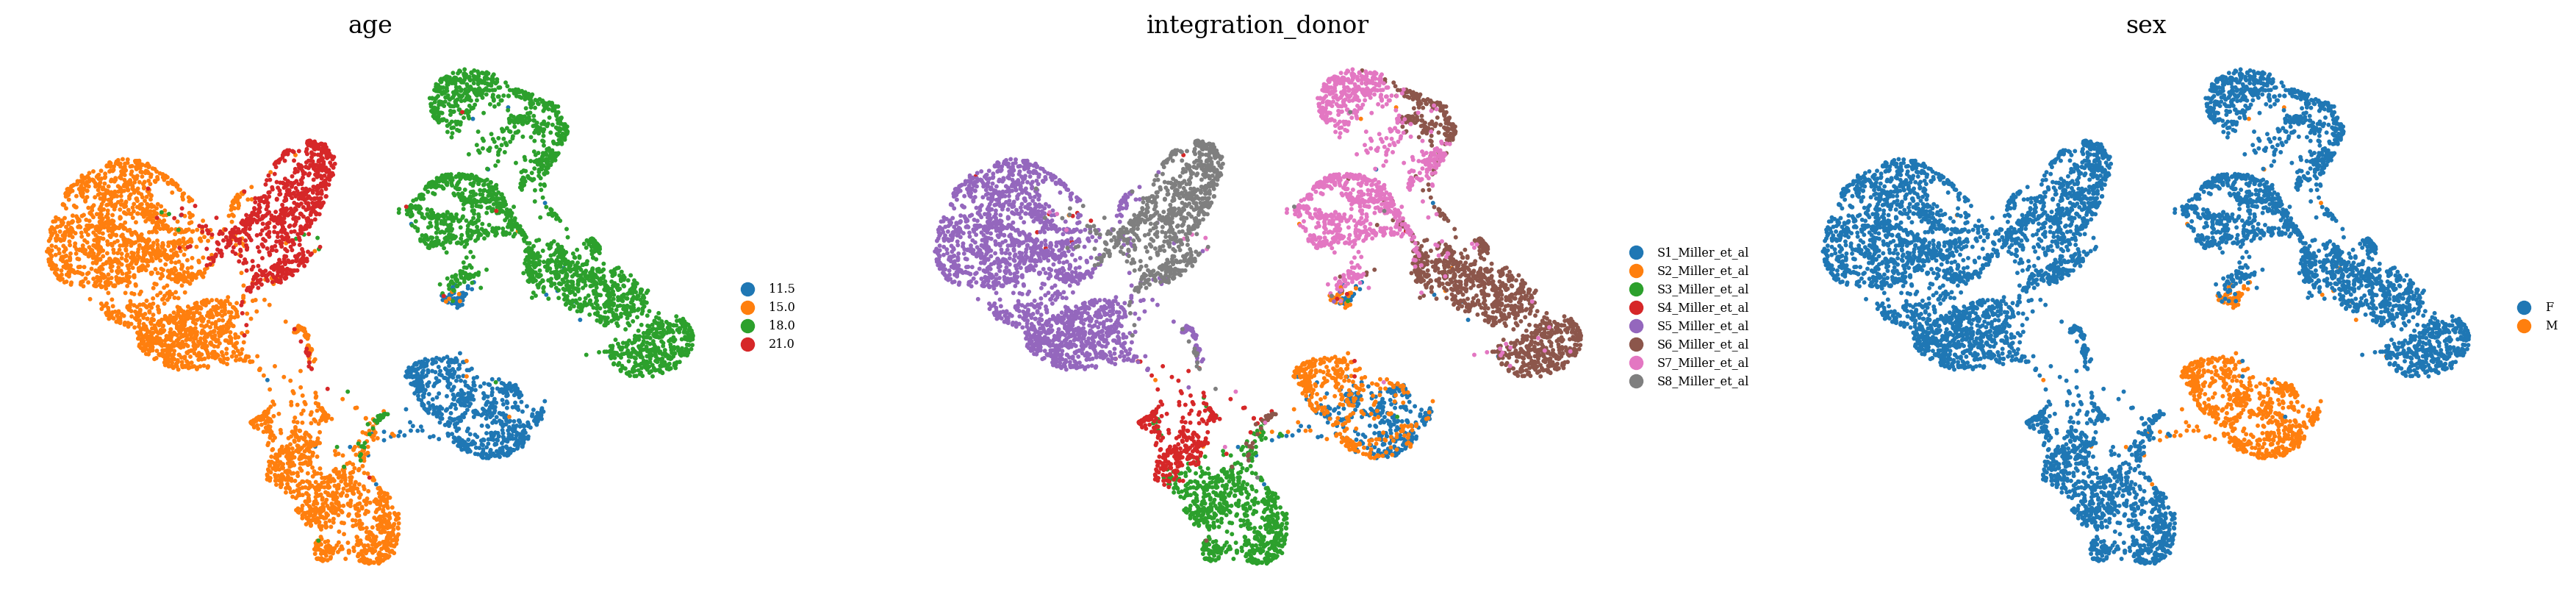

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [21]:
from tardis._disentanglementmanager import DisentanglementManager as DM

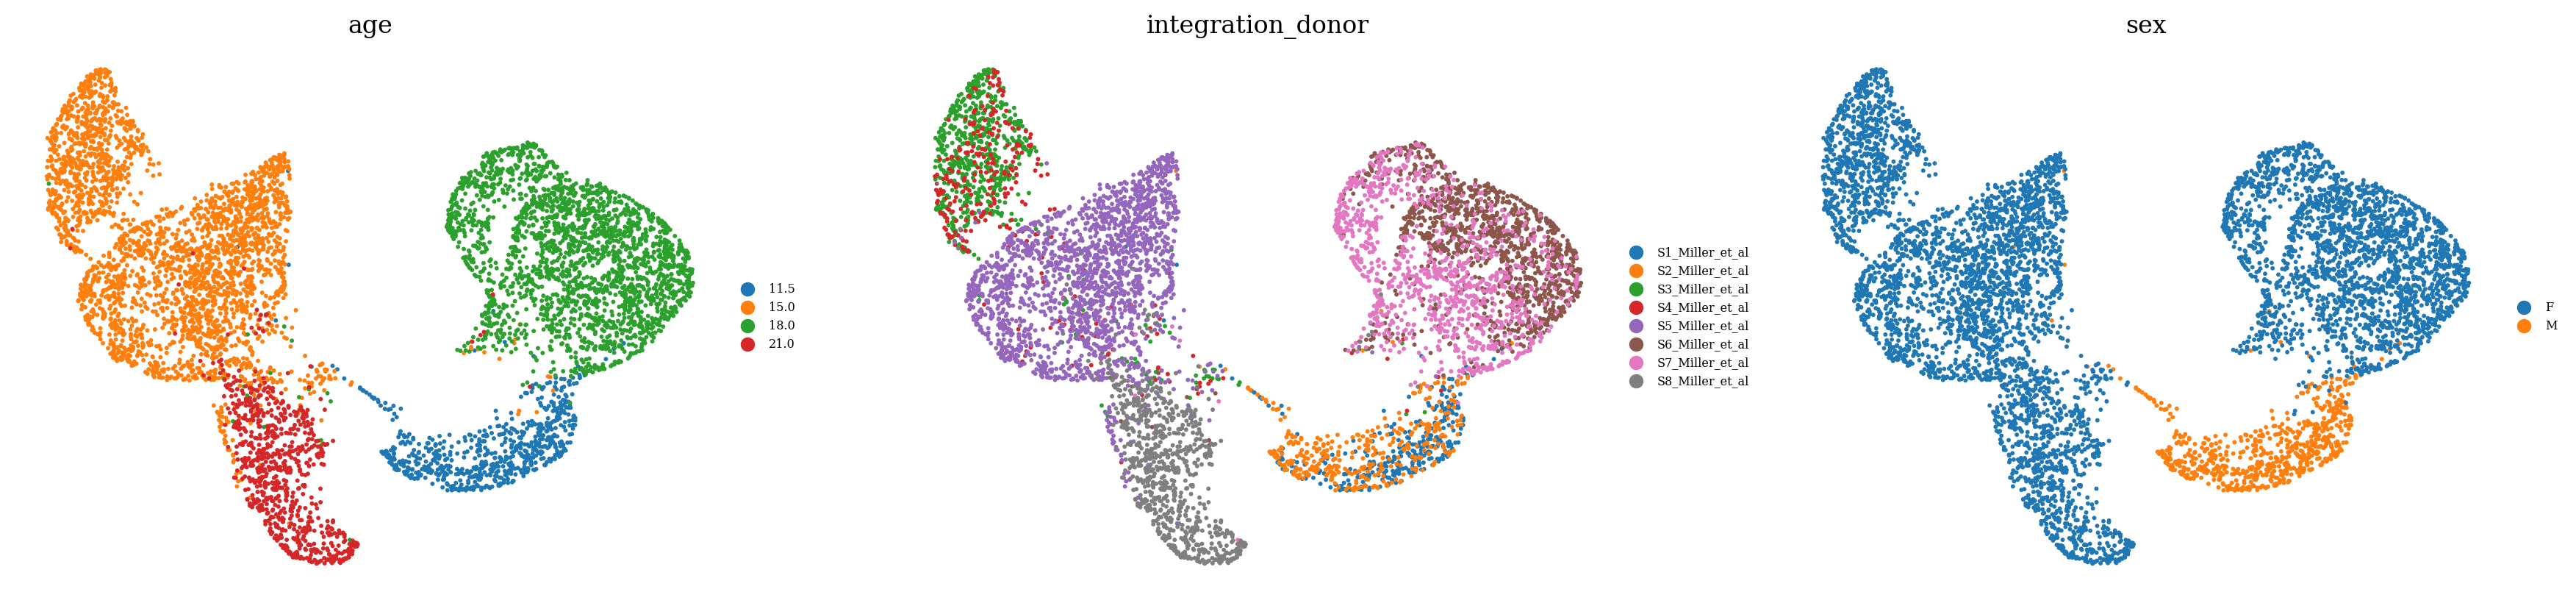

In [22]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

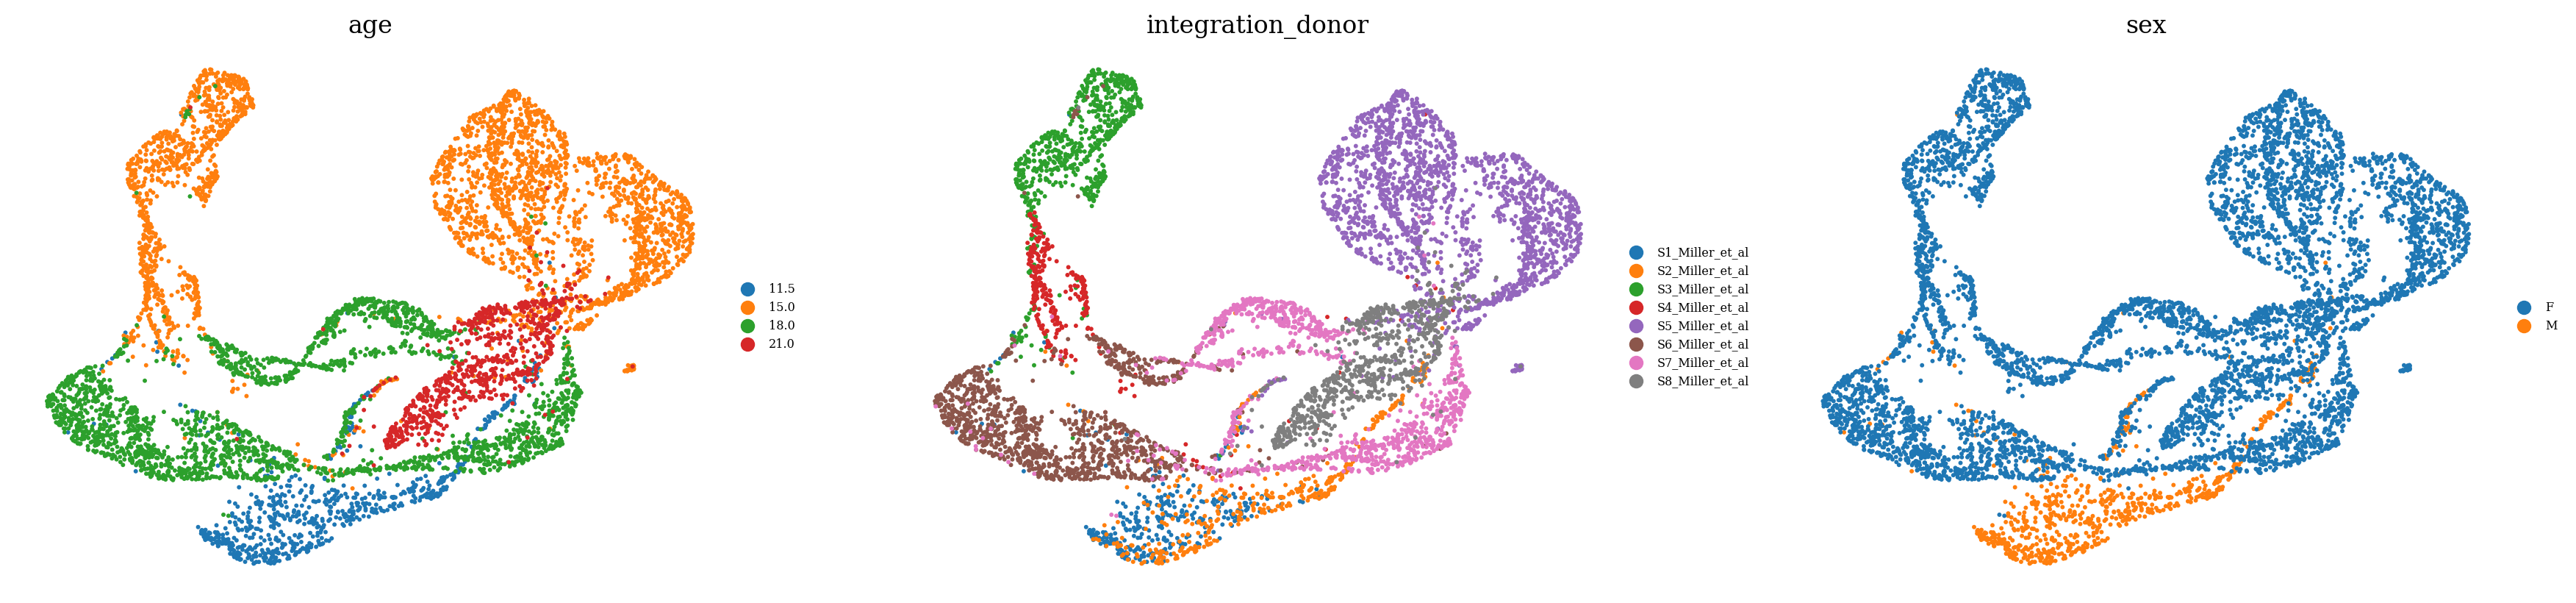

In [23]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("integration_donor").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [24]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs["age"] = adata_main.obs["age"].astype("str").astype("category")
adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [25]:
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main, n_neighbors = 30)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


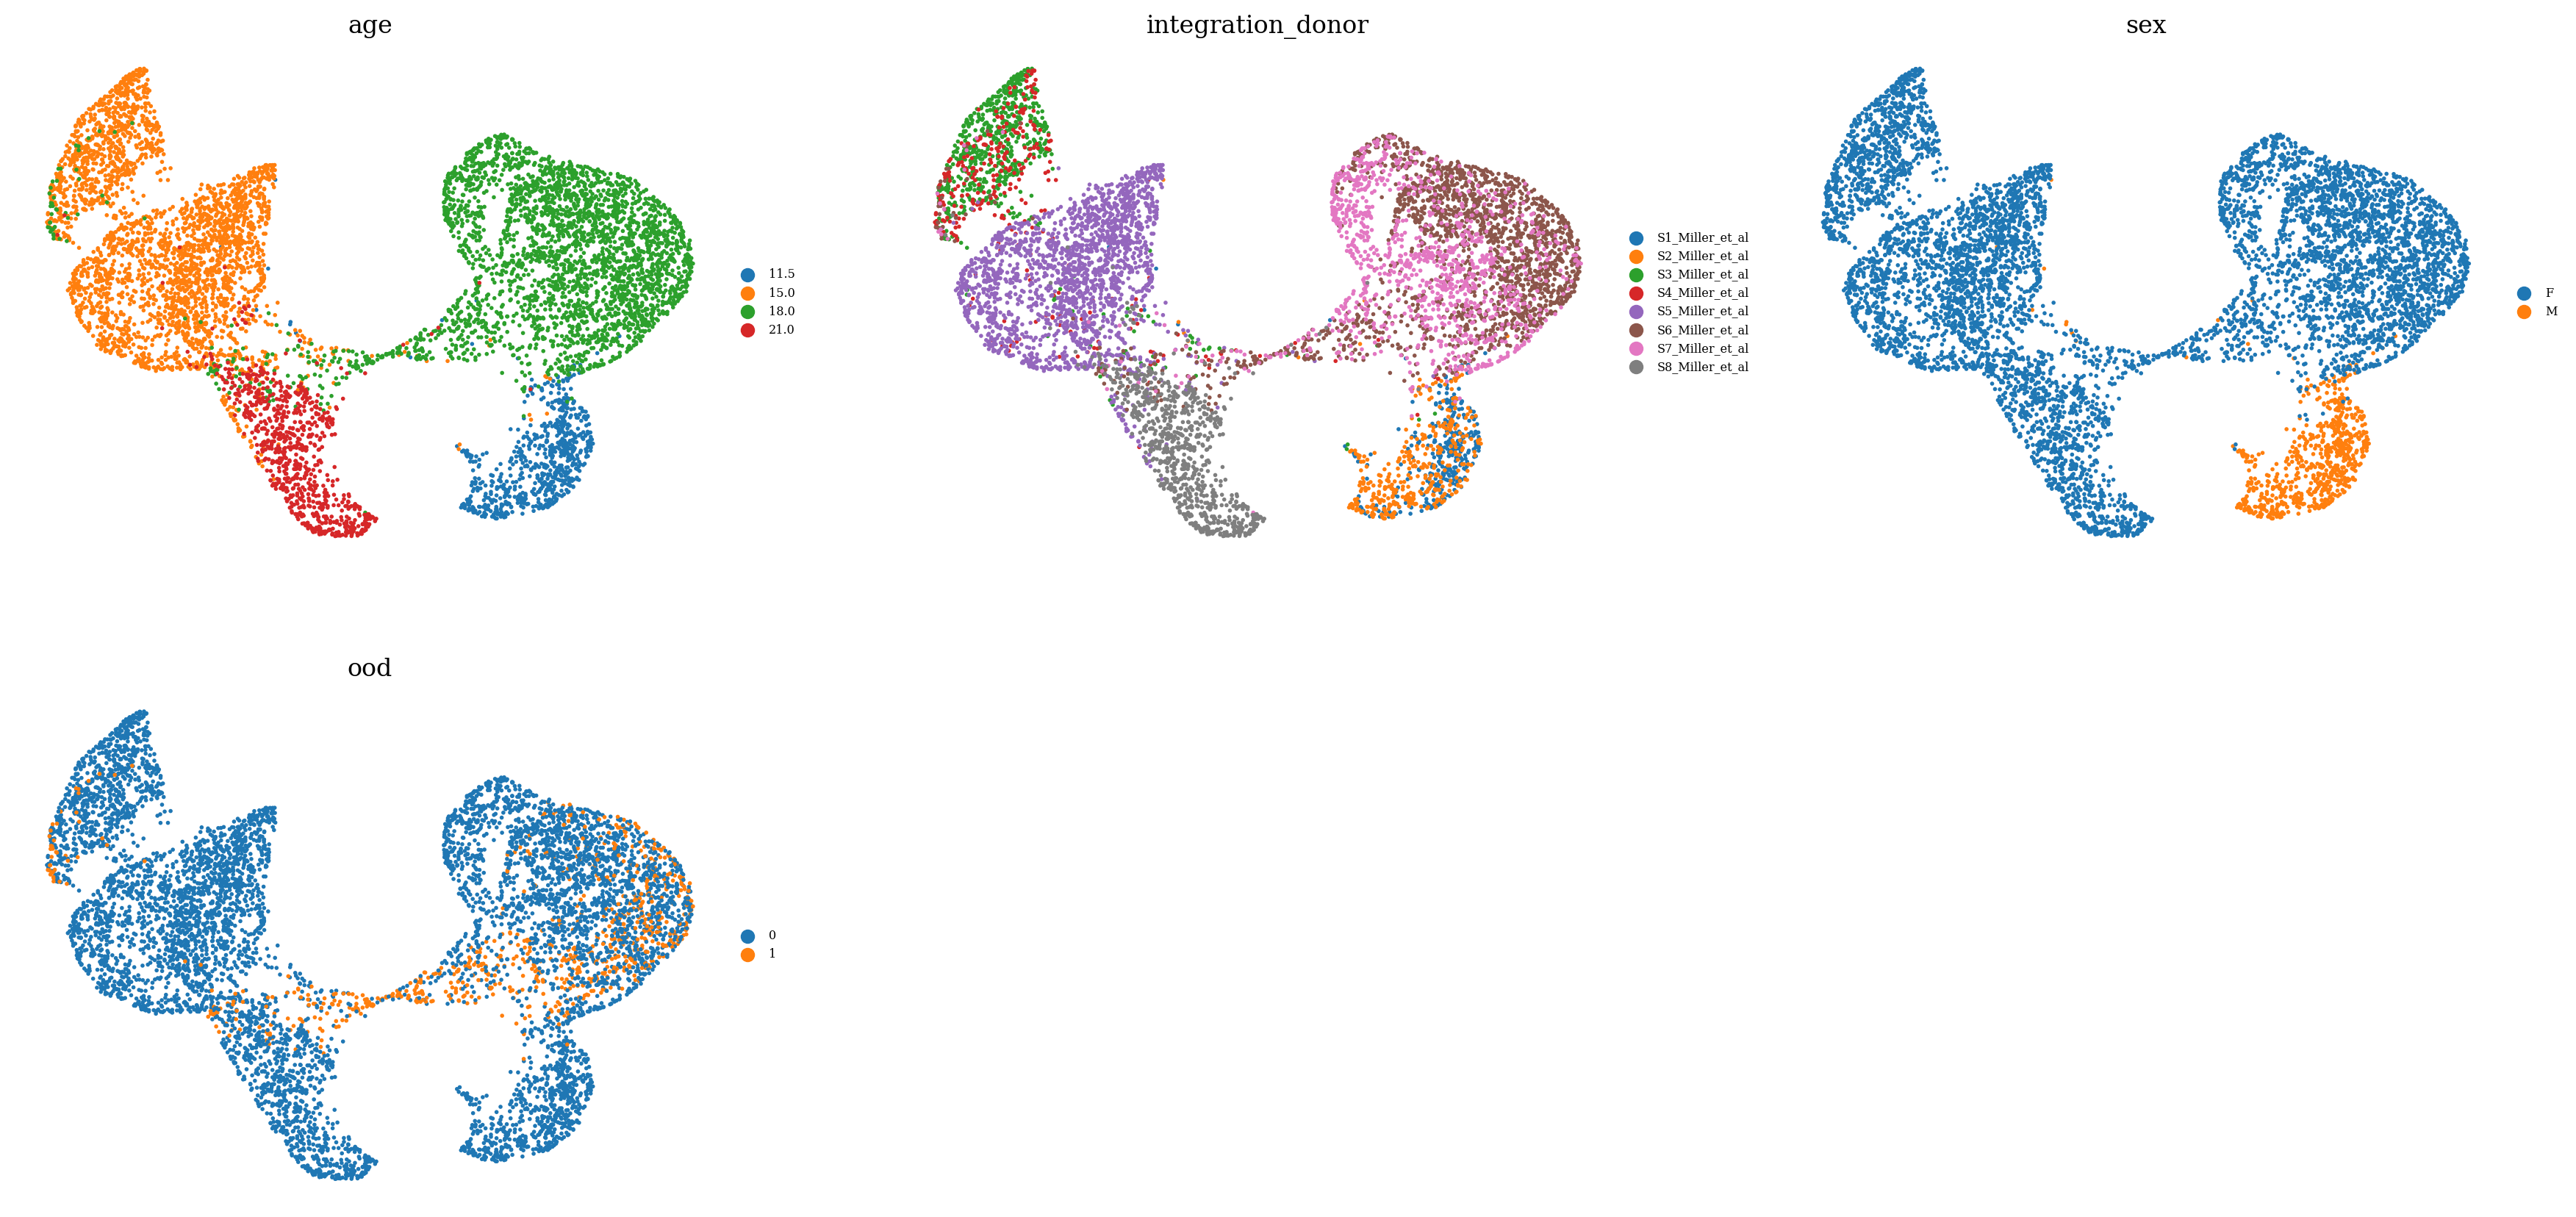

In [26]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=["age", "integration_donor", "sex", "ood"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [27]:
latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood, n_neighbors = 30)
sc.tl.umap(latent_ood)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [28]:
from scanpy.tools import Ingest as sc_Ingest
def label_transfer(
    reference_embeddings: ad.AnnData,
    query_embeddings: ad.AnnData,
    cluster_list: list[str],
    neighbors_count: int,
):
    # Compute a joint neighbor graph for reference and query embeddings
    joint_graph = sc_Ingest(reference_embeddings)
    joint_graph.fit(query_embeddings)
    joint_graph.neighbors(k=neighbors_count)

    # Calculate distances to top neighbors_count neighbors for each cell and store indices
    top_neighbor_distances, top_neighbor_indices = joint_graph._distances, joint_graph._indices

    # Transform distances with Gaussian kernel
    distance_stds = np.std(top_neighbor_distances, axis=1)
    distance_stds = (2.0 / distance_stds) ** 2
    distance_stds = distance_stds.reshape(-1, 1)
    transformed_distances = np.exp(-np.true_divide(top_neighbor_distances, distance_stds))

    # Normalize transformed distances so that they sum to 1
    normalized_weights = transformed_distances / np.sum(transformed_distances, axis=1, keepdims=True)

    # Initialize empty series to store predicted labels and uncertainties for each query cell
    cell_uncertainties = pd.Series(index=query_embeddings.obs_names, dtype="float64")
    predicted_labels = pd.Series(index=query_embeddings.obs_names, dtype="object")

    # Iterate through query cells
    for cluster in cluster_list:
        train_labels = reference_embeddings.obs[cluster].values
        for index in range(len(normalized_weights)):
            # Store cell types present among neighbors in reference
            unique_cell_types = np.unique(train_labels[top_neighbor_indices[index]])

            # Store best label and corresponding probability
            best_cell_type, best_probability = None, 0.0

            # Iterate through all cell types present among the cell's neighbors
            for label in unique_cell_types:
                prob = normalized_weights[index, train_labels[top_neighbor_indices[index]] == label].sum()
                if best_probability < prob:
                    best_probability = prob
                    best_cell_type = label
            else:
                final_label = best_cell_type

            # Store best label and corresponding uncertainty
            cell_uncertainties.iloc[index] = max(1 - best_probability, 0)
            predicted_labels.iloc[index] = final_label

        query_embeddings.obs[f"transf_{cluster}"] = predicted_labels
        query_embeddings.obs[f"transf_{cluster}_unc"] = cell_uncertainties

In [29]:
latent_ood

AnnData object with n_obs × n_vars = 777 × 8
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes', 'ood', '_scvi_batch', '_scvi_labels'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [30]:
label_transfer(latent, latent_ood, cluster_list=["age"], neighbors_count=30)

/Users/kemalinecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [31]:
latent_ood.obs

sample_ID organ   age               cell_type sex  \
Miller_S6_AAACCTGCAATCACAC        S6  Lung  18.0  Bud tip adjacent cells   F   
Miller_S6_AAACCTGCATGGTCAT        S6  Lung  18.0  Bud tip adjacent cells   F   
Miller_S6_AAACCTGGTTCAGGCC        S6  Lung  18.0  Bud tip adjacent cells   F   
Miller_S6_AAACCTGTCCCGGATG        S6  Lung  18.0  Bud tip adjacent cells   F   
Miller_S6_AAACCTGTCTGACCTC        S6  Lung  18.0  Bud tip adjacent cells   F   
...                              ...   ...   ...                     ...  ..   
Miller_S7_TTCCCAGCATAACCTG        S7  Lung  18.0  Bud tip adjacent cells   F   
Miller_S7_TTCCCAGTCGGGAGTA        S7  Lung  18.0  Bud tip adjacent cells   F   
Miller_S7_TTCTCAAGTTTAGCTG        S7  Lung  18.0  Bud tip adjacent cells   F   
Miller_S7_TTGGCAATCCTGCTTG        S7  Lung  18.0  Bud tip adjacent cells   F   
Miller_S7_TTGTAGGGTACCGTTA        S7  Lung  18.0  Bud tip adjacent cells   F   

                           sex_inferred concatenated_integration_covariates  \
Miller_S6_AAACCTGCAATCACAC            F     S6_Miller_et_al_Cell_Fresh_3GEX   
Miller_S6_AAACCTGCATGGTCAT            F     S6_Miller_et_al_Cell_Fresh_3GEX   
Miller_S6_AAACCTGGTTCAGGCC            F     S6_Miller_et_al_Cell_Fresh_3GEX   
Miller_S6_AAACCTGTCCCGGATG            F     S6_Miller_et_al_Cell_Fresh_3GEX   
Miller_S6_AAACCTGTCTGACCTC            F     S6_Miller_et_al_Cell_Fresh_3GEX   
...                                 ...                                 ...   
Miller_S7_TTCCCAGCATAACCTG            F     S7_Miller_et_al_Cell_Fresh_3GEX   
Miller_S7_TTCCCAGTCGGGAGTA            F     S7_Miller_et_al_Cell_Fresh_3GEX   
Miller_S7_TTCTCAAGTTTAGCTG            F     S7_Miller_et_al_Cell_Fresh_3GEX   
Miller_S7_TTGGCAATCCTGCTTG            F     S7_Miller_et_al_Cell_Fresh_3GEX   
Miller_S7_TTGTAGGGTACCGTTA            F     S7_Miller_et_al_Cell_Fresh_3GEX   

                           integration_donor integration_biological_unit  \
Miller_S6_AAACCTGCAATCACAC   S6_Miller_et_al                        Cell   
Miller_S6_AAACCTGCATGGTCAT   S6_Miller_et_al                        Cell   
Miller_S6_AAACCTGGTTCAGGCC   S6_Miller_et_al                        Cell   
Miller_S6_AAACCTGTCCCGGATG   S6_Miller_et_al                        Cell   
Miller_S6_AAACCTGTCTGACCTC   S6_Miller_et_al                        Cell   
...                                      ...                         ...   
Miller_S7_TTCCCAGCATAACCTG   S7_Miller_et_al                        Cell   
Miller_S7_TTCCCAGTCGGGAGTA   S7_Miller_et_al                        Cell   
Miller_S7_TTCTCAAGTTTAGCTG   S7_Miller_et_al                        Cell   
Miller_S7_TTGGCAATCCTGCTTG   S7_Miller_et_al                        Cell   
Miller_S7_TTGTAGGGTACCGTTA   S7_Miller_et_al                        Cell   

                           integration_sample_status  \
Miller_S6_AAACCTGCAATCACAC                     Fresh   
Miller_S6_AAACCTGCATGGTCAT                     Fresh   
Miller_S6_AAACCTGGTTCAGGCC                     Fresh   
Miller_S6_AAACCTGTCCCGGATG                     Fresh   
Miller_S6_AAACCTGTCTGACCTC                     Fresh   
...                                              ...   
Miller_S7_TTCCCAGCATAACCTG                     Fresh   
Miller_S7_TTCCCAGTCGGGAGTA                     Fresh   
Miller_S7_TTCTCAAGTTTAGCTG                     Fresh   
Miller_S7_TTGGCAATCCTGCTTG                     Fresh   
Miller_S7_TTGTAGGGTACCGTTA                     Fresh   

                           integration_library_platform_coarse  n_genes ood  \
Miller_S6_AAACCTGCAATCACAC                                3GEX      116   1   
Miller_S6_AAACCTGCATGGTCAT                                3GEX       71   1   
Miller_S6_AAACCTGGTTCAGGCC                                3GEX      103   1   
Miller_S6_AAACCTGTCCCGGATG                                3GEX      163   1   
Miller_S6_AAACCTGTCTGACCTC                                3GEX       59   1   
...                                                      

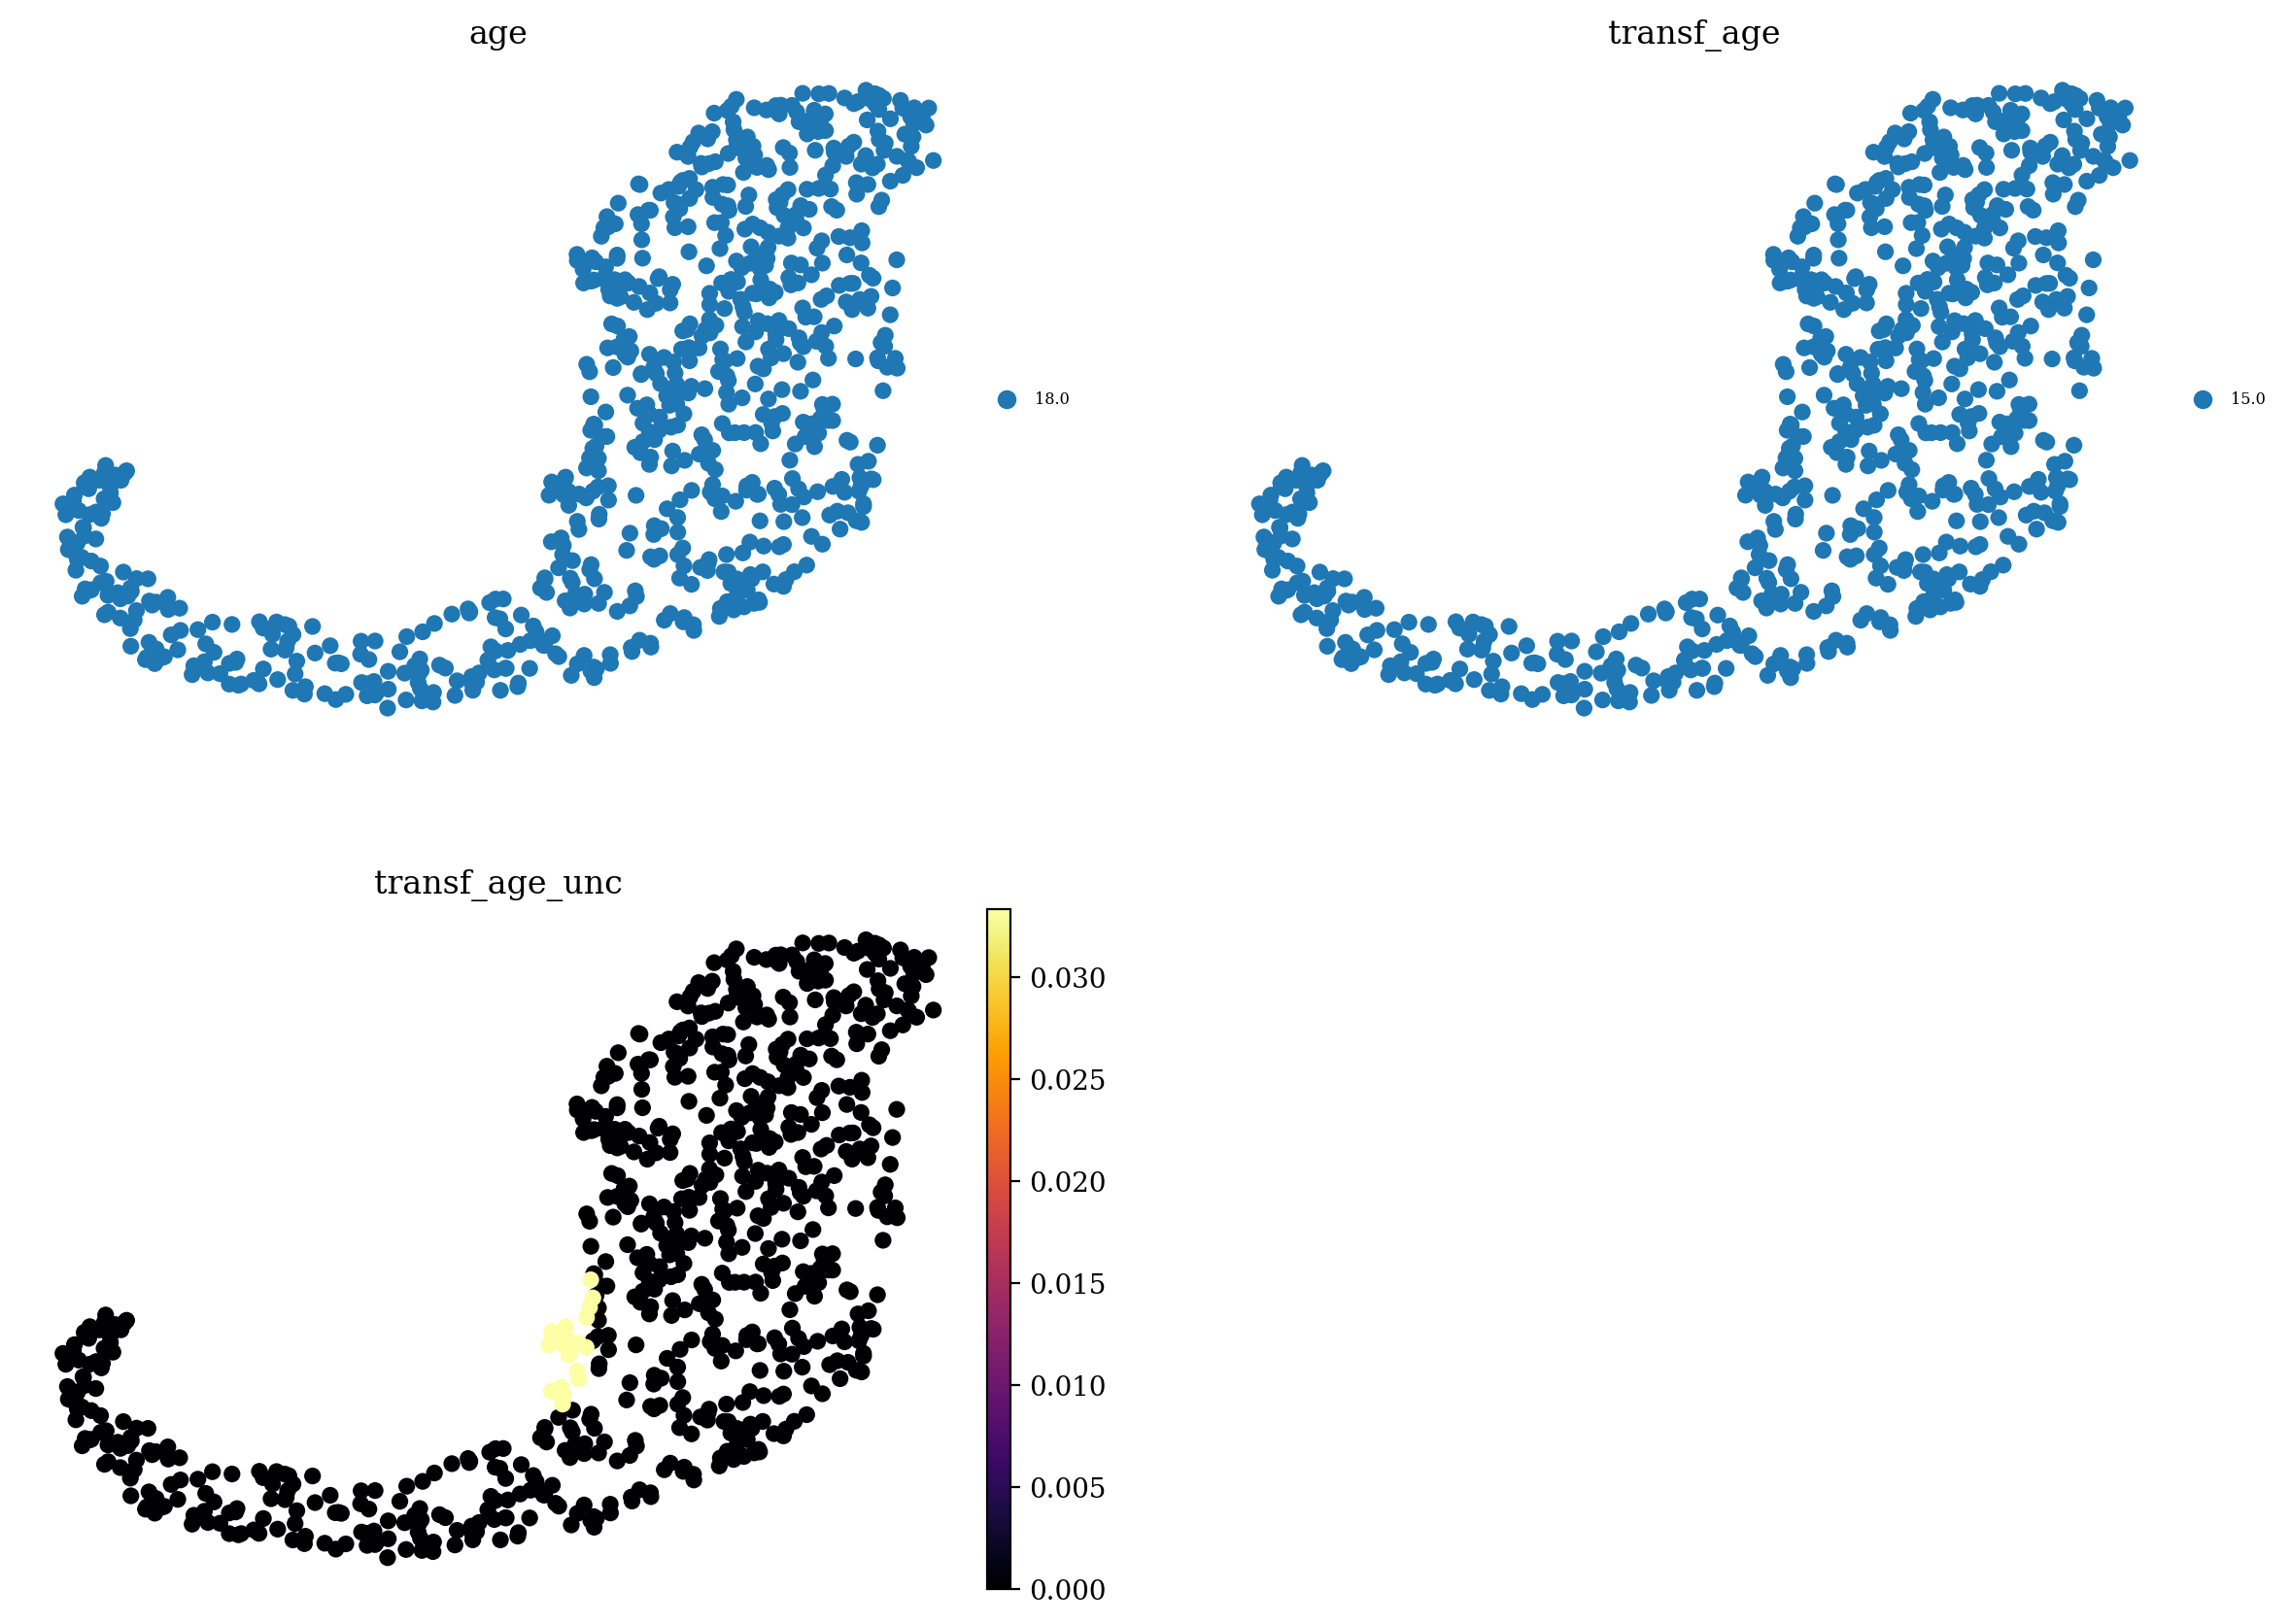

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=["age", "transf_age", "transf_age_unc"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [33]:
k = "age"
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

In [34]:
import sklearn

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)
metrics

{'accuracy': 0.0,
 'precision_macro': 0.0,
 'recall_macro': 0.0,
 'f1_score_macro': 0.0,
 'precision_micro': 0.0,
 'recall_micro': 0.0,
 'f1_score_micro': 0.0,
 'precision_weighted': 0.0,
 'recall_weighted': 0.0,
 'f1_score_weighted': 0.0,
 'confusion_matrix': array([[  0,   0],
        [777,   0]])}

In [35]:
np.sum(latent.obs['age'] == '15.0')/len(latent)

0.4411587205793603